# Wavelet U-Net
<u>Project Title</u>: Supervised Robot Tool Image Segmentation and Generation Methods \
<u>Group: 16</u> \
<u>Authors:</u> Aryaman Shodhan ashodha1,
Trisha Karani tkarani1,
Shreya Wadhwa swadhwa5,
Aidan Aug aaug1

---

**Notebook description**: This Colab Notebook implements the Wavelet U-Net, which uses wavelet transforms to replace the pooling and upsampling operations performed in the original U-Net architecture



# Setup: 

Mounting Drive, importing libraries, and determining device

In [20]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
from datetime import datetime
from pytz import timezone
tz = timezone('US/Eastern')

In [22]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

# Data Preprocessing

NOTE: MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE CholecSeg8k DATA!!!

The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Shuffles the data
3. Splits data into an 60:10:10 train-val-test split
4. Generates an ImageDataset class based on this data for feeding into a dataloader
5. Resizes images into 192 x 320 pixel images
6. Visualizes data

In [23]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
# data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" # Aidan Second Account


mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [24]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [25]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [26]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [27]:
train_batch_size = 8 #32
validation_batch_size = 8 #32
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None), #Ratios must be compatible with UNet
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 75
Batches of Validation Dataloader: 13
Batches of Testing Dataloader: 100


### Visualize Data

In [28]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

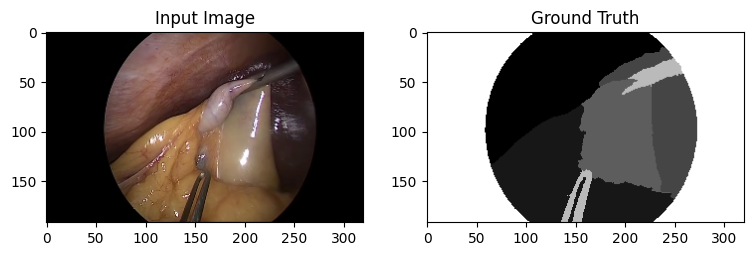

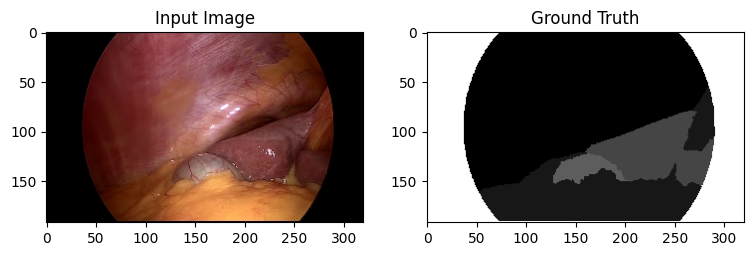

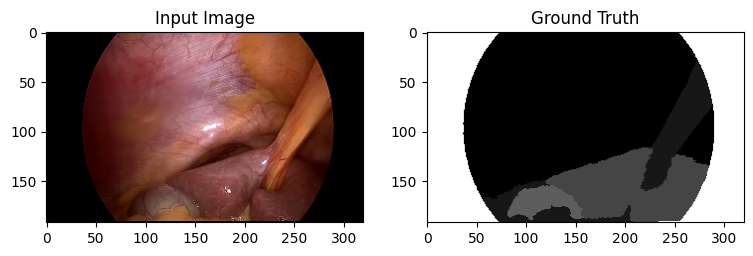

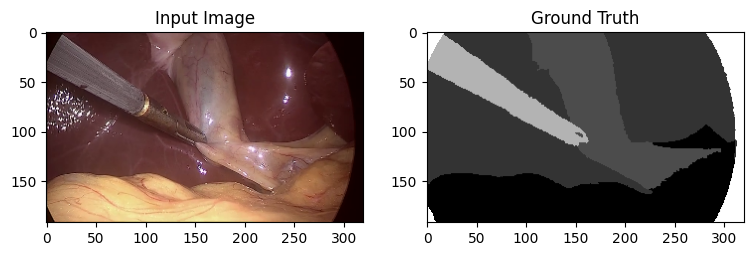

In [29]:
visualize(train_dataloader, n_samples=4)

# Loss Functions

TODO: INCLUDE DESCRIPTION OF RATIONALE BEHIND DICELOSS AND IOU

Dice Loss

Remember to include references about where we got the equation from!

https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf

In [30]:
# IOU Loss = 1 - (|A intersect B| / |A union B|)
class IOULoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(IOULoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks, n_classes):
    batch_size = target_masks.shape[0]
    iou_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      iou_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        iou_classes[cl] = intersection / (predicted_mask[cl].sum() + target_mask[cl].sum() - intersection)
      iou_scores[batch] = iou_classes.mean()
    return 1.0 - iou_scores.mean()

In [31]:
# DICE Loss = 1 - (2 * |A intersect B| / (|A| + |B|))
class DICELoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(DICELoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks):
    n_classes = predicted_masks.shape[1]
    batch_size = target_masks.shape[0]
    dice_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      dice_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        dice_classes[cl] = 2 * intersection / (predicted_mask[cl].sum() + target_mask[cl].sum())
      dice_scores[batch] = dice_classes.mean()
    return 1.0 - dice_scores.mean()

In [32]:
## Loss Functions Testing

# Batch has 1 item with 3 classes
predicted = torch.Tensor([
    # Class 1
    [[[0.2, 0.1, 0.05],
    [0.1, 0.3, 0.4],
    [0.6, 0.75, 0.25]],

    # Class 2
    [[0.25, 0.1, 0.9],
    [0.45, 0.2, 0.3],
    [0.2, 0.15, 0.05]],

    # Class 3
    [[0.55, 0.8, 0.05],
    [0.45, 0.5, 0.3],
    [0.2, 0.1, 0.7]]]
])

# Batch has 1 item with 3 classes
target = torch.Tensor([
    # Class 1
    [[[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0]],

    # Class 2
    [[1, 0, 1],
    [0, 1, 0],
    [0, 1, 0]],

    # Class 3
    [[0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]]
])

# IOU Score for Class 1: 1.0 / (2.0 + 2.75 - 1.0) = 0.2667
# IOU Score for Class 2: 1.5 / (4.0 + 2.6 - 1.5) = 0.2941
# IOU Score for Class 3: 1.95 / (3.0 + 3.65 - 1.95) = 0.4149
# Mean IOU Score: 0.3252
# Loss = 1 - 0.3252 = 0.6748
iou = IOULoss()
iou_loss = iou.forward(predicted, target, n_classes=3).item()
assert(iou_loss == 0.6747740507125854)

# DICE Score for Class 1: 2 * 1.0 / (2.0 + 2.75) = 0.4211
# DICE Score for Class 2: 2 * 1.5 / (4.0 + 2.6) = 0.4545
# DICE Score for Class 3: 2 * 1.95 / (3.0 + 3.65) = 0.5865
# Mean DICE Score: 0.4874
# Loss = 1 - 0.4874 = 0.5126
dice = DICELoss()
# dice_loss = dice.forward(predicted, target, n_classes=3).item()
dice_loss = dice.forward(predicted, target).item()

assert(dice_loss == 0.5126452445983887)

In [33]:
def dice_score_image(prediction, target, n_classes):
    dice_classes = np.zeros(n_classes)

    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, use_gpu=False, is_deeplab_or_fcn=False):
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)

    model.eval()
    idx = 0
    for data in dataloader:

        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()

        out = model(img)
        if is_deeplab_or_fcn:
          out = out['out']
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = nn.functional.one_hot(prediction, n_classes)
        prediction = prediction.permute(0, 3, 1, 2)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1

    m_dice = scores.mean()
    return m_dice

# Training and Validation

In [34]:
def test_eval(test_dataloader, model, loss, verbose = 1, is_deeplab_or_fcn=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          if i <= 5:
            fig, ax = plt.subplots(1, 3)
            img = outputs[0]
            img = np.argmax(img.cpu().numpy(), axis=0)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title("Predicted")    

            ax[1].imshow(np.argmax(labels[0].cpu().numpy(), axis=0), cmap="gray")
            ax[1].set_title("Labels")

            input = images[0].permute(1, 2, 0).cpu().numpy()
            ax[2].imshow(input)
            ax[2].set_title("Input")

            plt.show()
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [35]:
def val_eval(val_dataloader, model, loss, verbose = 0, is_deeplab_or_fcn=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Val loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [36]:
def train(model, train_data_loader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False):

  loss_fail = 0
  patience = 5
  best_model = model
  best_val_loss = float('inf')
  n_classes = 13
  print("Start Training...")
  print("{:<10} {:<20} {:<20} {:<20} {:<15} {:<15}".format('epoch', 'train loss','val loss', 'es_counter(/5)', 'min_val_loss', 'time(s)'))
  time_start = time.time() #timekeeping
  for epoch in range(num_epochs):
      ########################### Training #####################################
      time_epoch_start = time.time() #timekeeping
      loss_sum = 0
      correct = 0
      total = 0
      for i, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        if is_deeplab_or_fcn:
          outputs = outputs['out'] #only for DeepLabV3

        loss_val = loss(outputs, y)
        loss_val.backward()
        optimizer.step()

        # train eval
        loss_sum += loss_val.item()
        total += y.size(0)

      train_loss = loss_sum / total

      ########################### Validation #####################################
      val_loss = val_eval(validation_dataloader, model, loss, is_deeplab_or_fcn)

      # Early Stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        loss_fail = 0
      else:
        loss_fail += 1
      
      if loss_fail == patience:
          print("Stopping Early..")
          print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n", "Train Loss:",train_loss, "Validation Loss:",val_loss)
          break

      # Timekeeping
      time_epoch_end = time.time()
      total_time = time_epoch_end - time_start

      # Print statements + data keeping for graph
      if epoch % 2 == 0:
          print("{:<10} {:<20f} {:<20f} {:<20d} {:<15f} {:<15f}".format(
            epoch, train_loss, val_loss, loss_fail, round(best_val_loss,10), total_time))
      if epoch == 0:
          L = train_loss
          A = val_loss
      else:
          L = np.append(L,train_loss)
          A = np.append(A,val_loss)

  ## Plot Training Loss and Validation Loss
  plt.plot(L,'-', label='Training Loss')
  plt.plot(A,'-', label='Validation Loss')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='best')
  plt.show()

  return best_model

# EXPERIMENT 1 Comparing different segmentation models

This notebook explores the performance of a U-Net model for image segmentation, using BatchNorm2d, LeakyReLU, and MaxPool2D layers.

## WaveletUNet

In this model, we use the low frequency band (LL) as the downsampled image, and later reinject the high frequency bands when upsampling.

### Restart Runtime

In [ ]:
torch.cuda.empty_cache()

### Define Model

In [ ]:
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 978 (delta 79), reused 91 (delta 46), pack-reused 836
Receiving objects: 100% (978/978), 6.80 MiB | 36.84 MiB/s, done.
Resolving deltas: 100% (663/663), done.
/content/pytorch_wavelets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54871 sha256=78f05e2cccb5d43058925716d20a515182f25091694d2b23b089b6cd1bf6ca69
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbmc9s0j/wheels/f6/77/89/ac0462961f441a5dd4d226216613ef64f3eb2c7f2883efcebf
Successfully built pytorch-wavelets


In [ ]:
import pytorch_wavelets as pw

class WaveletTransform(nn.Module):
    def __init__(self, filter='haar', use_gpu=use_gpu):
      super(WaveletTransform, self).__init__()
      self.dwt = pw.DWT(1, filter, 'zero')
      if (use_gpu):
        self.dwt.cuda()

    def forward(self, x):
        yl, yh = self.dwt(x)
        return yl, yh

class WaveletInverseTransform(nn.Module):
    def __init__(self, filter='haar'):
      super(WaveletInverseTransform, self).__init__()
      self.idwt = pw.IDWT(filter, 'zero')
      if (use_gpu):
        self.idwt.cuda()

    def forward(self, yl, yh):
      return self.idwt((yl, yh))


## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def conv_1x1(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 1, 1, 0, bias=False),
                    nn.ReLU())


import torch.nn as nn


# U-Net
class WaveletUNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(WaveletUNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # WAVELET TRANSFORM TO DOWNSAMPLE
        self.downsample = WaveletTransform()
        self.upsample = WaveletInverseTransform()
        self.conv1x1_4= conv_1x1(256, 128)
        self.conv1x1_3= conv_1x1(128, 64)
        self.conv1x1_2= conv_1x1(64, 32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()
        self.relu = nn.ReLU()


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        yl_1, yh_1 = self.downsample(conv1_out)
        conv2_out = self.conv2(yl_1)
        yl_2, yh_2 = self.downsample(conv2_out)
        conv3_out = self.conv3(yl_2)
        yl_3, yh_3 = self.downsample(conv3_out)
        conv4_out = self.conv4(yl_3)

        conv4_out = self.conv1x1_4(conv4_out)
        conv4m_out_ = torch.cat((self.relu(self.upsample(conv4_out, yh_3)), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out = self.conv1x1_3(conv3m_out)
        conv3m_out_ = torch.cat((self.relu(self.upsample(conv3m_out, yh_2)), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        
        conv2m_out = self.conv1x1_2(conv2m_out)
        conv2m_out_ = torch.cat((self.relu(self.upsample(conv2m_out, yh_1)), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


### Visualize Wavelet Transform

In [ ]:
def visualize_wavelet(dataloader, n_batches=1, n_samples=1, normalize=False):
    wavelet_transform = WaveletTransform(use_gpu=False)

    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        yl, yh = wavelet_transform(img)
        yll = yl
        ylh = yh[0][:,:,0,:,:]
        yhl = yh[0][:,:,1,:,:]
        yhh = yh[0][:,:,2,:,:]
        yll = (yll - yll.min()) / (yll.max() - yll.min())

        if normalize:
          ylh = (ylh - ylh.min()) / (ylh.max() - ylh.min())
          yhl = (yhl - yhl.min()) / (yhl.max() - yhl.min())
          yhh = (yhh - yhh.min()) / (yhh.max() - yhh.min())

        yll_ylh = torch.cat((yll, ylh), 3)
        yhl_yhh = torch.cat((yhl, yhh), 3)

        wavelet_img = torch.cat((yll_ylh, yhl_yhh), 2)
        
        img = img.numpy().transpose(0, 2, 3, 1)
        wavelet_img = wavelet_img.numpy().transpose(0, 2, 3, 1)
        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(wavelet_img[i], cmap="gray")
            ax[1].set_title("Wavelet Transform")

        plt.show()

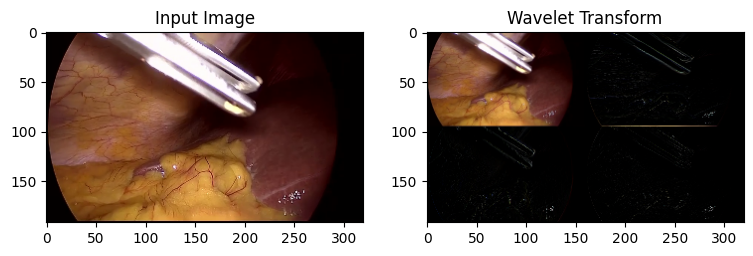

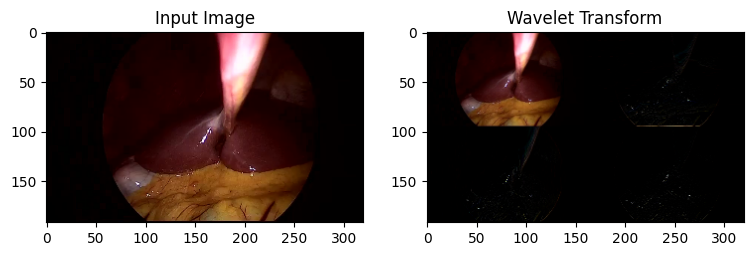

In [ ]:
visualize_wavelet(train_dataloader, n_samples=2)

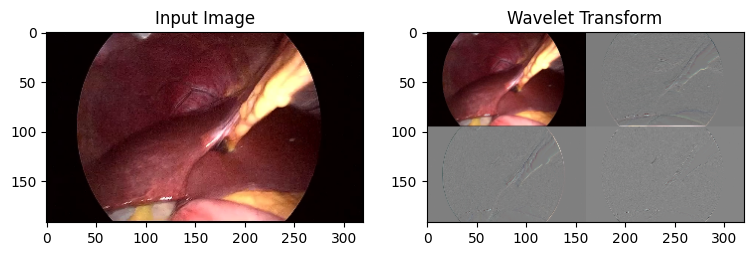

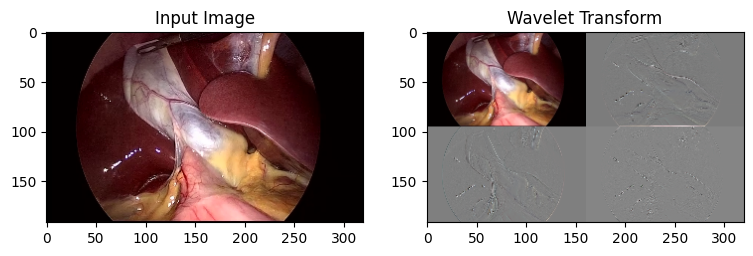

In [ ]:
visualize_wavelet(train_dataloader, n_samples=2, normalize=True)

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.078052             0.090397             0                    0.090397        492.646639     
2          0.071000             0.083914             0                    0.083914        673.657152     
4          0.066831             0.079263             0                    0.079263        856.945005     
6          0.064026             0.076995             0                    0.076995        1036.707614    
8          0.062245             0.074761             0                    0.074761        1219.420475    
10         0.060818             0.072884             0                    0.072884        1400.299945    
12         0.060085             0.072379             0                    0.072379        1577.026504    
14         0.059261             0.071493             0                    0.071493        1756.582412    
16         0.058646         

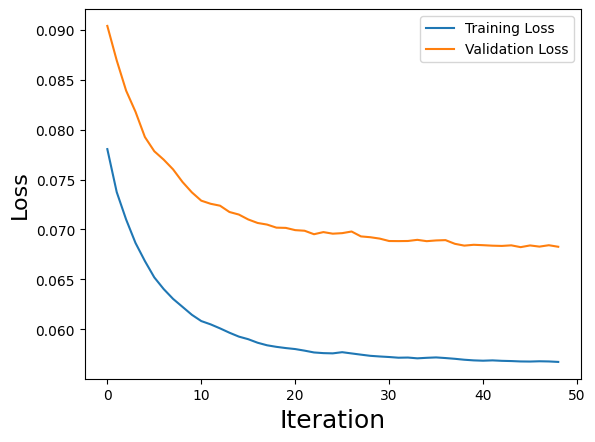

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = WaveletUNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
loss = torch.nn.CrossEntropyLoss()
wavelet_unet_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

In [ ]:
dice_score_dataset(wavelet_unet_trained, test_dataloader, n_classes)

0.9396257051246818

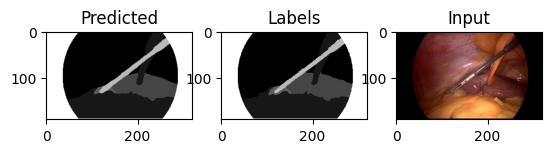

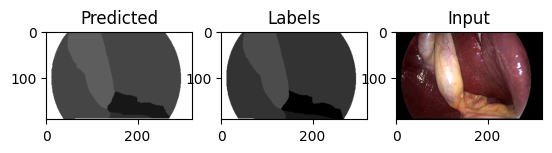

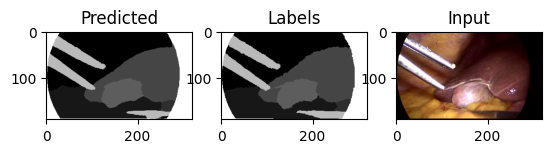

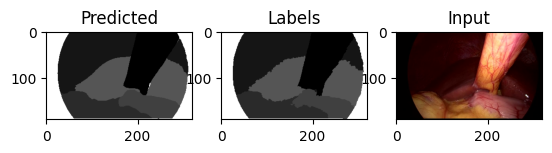

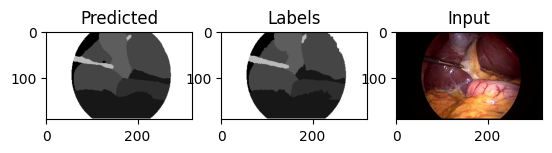

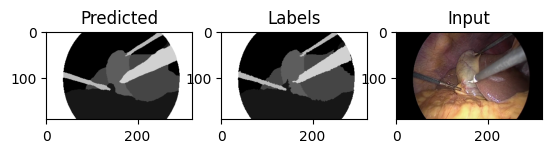

Test loss: 1.704642


1.7046420326358598

In [ ]:
test_eval(test_dataloader, wavelet_unet_trained, loss)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(wavelet_unet_trained, data_dir + f"saved_models/models/wavelet_unet_{cur_time}.pt")

## WaveletUNet 2.0

Instead of using the approximation coefficients to upsample directly, we can concatenate the output to feed into the next layer, which "downsamples" the image.

### Define Model

In [37]:
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 978 (delta 79), reused 91 (delta 46), pack-reused 836
Receiving objects: 100% (978/978), 6.80 MiB | 27.09 MiB/s, done.
Resolving deltas: 100% (663/663), done.
/content/pytorch_wavelets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54854 sha256=11ef784bc992e5eae2e678f7c91a1e2a0a2464d9fbd670170ef162ecd90dd2fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-d8tn1tb_/wheels/f6/77/89/ac0462961f441a5dd4d226216613ef64f3eb2c7f2883efcebf
Successfully built pytorch-wavelets


In [39]:
import pytorch_wavelets as pw

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class WaveletTransform(nn.Module):
    def __init__(self, filter='haar', use_gpu=use_gpu):
      super(WaveletTransform, self).__init__()
      self.dwt = pw.DWT(1, filter, 'zero')
      if (use_gpu):
        self.dwt.cuda()

    def forward(self, x):
        yl, yh = self.dwt(x)
        return yl, yh

class WaveletInverseTransform(nn.Module):
    def __init__(self, filter='haar'):
      super(WaveletInverseTransform, self).__init__()
      self.idwt = pw.IDWT(filter, 'zero')
      if (use_gpu):
        self.idwt.cuda()

    def forward(self, yl, yh):
      return self.idwt((yl, yh))


## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def conv_1x1(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 1, 1, 0, bias=False),
                    nn.ReLU())


import torch.nn as nn


# U-Net
class WaveletUNET2(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(WaveletUNET2, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)

        # Residual block
        self.residual_block = ResidualBlock(128, 128)

        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # WAVELET TRANSFORM TO DOWNSAMPLE
        self.downsample = WaveletTransform()
        self.upsample = WaveletInverseTransform()
        self.conv1x1_4= conv_1x1(256, 128)
        self.conv1x1_3= conv_1x1(128, 64)
        self.conv1x1_2= conv_1x1(64, 32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Softmax(dim=1)
        self.relu = nn.LeakyReLU(0.1)


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        yl, yh = self.downsample(conv1_out)

        # Create a new image with each quadrant a part of the wavelet transform
        yl = getConcatenatedWT(yl, yh)

        conv2_out = self.conv2(yl)
        yl, yh = self.downsample(conv2_out)
        yl = getConcatenatedWT(yl, yh)
        conv3_out = self.conv3(yl)
        yl, yh = self.downsample(conv3_out)
        yl = getConcatenatedWT(yl, yh)
        conv4_out = self.conv4(yl)
        yl, yh = self.downsample(conv4_out)
        yl = getConcatenatedWT(yl, yh)

        conv4_out = self.residual_block(self.conv1x1_4(conv4_out))
        yl, yh = getCoeffFromConcatenatedWT(conv4_out)
        conv4m_out_ = torch.cat((self.relu(self.upsample(yl, yh)), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out = self.conv1x1_3(conv3m_out)
        yl, yh = getCoeffFromConcatenatedWT(conv3m_out)
        conv3m_out_ = torch.cat((self.relu(self.upsample(yl, yh)), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        
        conv2m_out = self.conv1x1_2(conv2m_out)
        yl, yh = getCoeffFromConcatenatedWT(conv2m_out)
        conv2m_out_ = torch.cat((self.relu(self.upsample(yl, yh)), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


def getConcatenatedWT(yl, yh):
    return torch.cat((torch.cat((yl, yh[0][:,:,0,:,:]), 3), torch.cat((yh[0][:,:,1,:,:], yh[0][:,:,2,:,:]), 3)), 2)

def getCoeffFromConcatenatedWT(concatWT):
    x_len = concatWT.shape[2]//2
    y_len = concatWT.shape[3]//2
    
    yll_ylh, yhl_yhh = torch.split(concatWT, x_len, dim=2)

    yll, ylh = torch.split(yll_ylh, y_len, dim=3)
    yhl, yhh = torch.split(yhl_yhh, y_len, dim=3)

    yh = [torch.stack((ylh, yhl, yhh), dim=2)]


    return yll, yh

### Training

In [ ]:
torch.cuda.empty_cache()
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = WaveletUNET2(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
loss = torch.nn.CrossEntropyLoss()
wavelet_unet_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.284476             0.274711             0                    0.274711        476.626606     
2          0.238131             0.247731             0                    0.247731        898.516714     
4          0.233255             0.244163             0                    0.244163        1323.683047    
6          0.229549             0.241431             0                    0.241431        1747.267544    
8          0.228043             0.238099             0                    0.238099        2171.002568    
10         0.226053             0.236122             0                    0.236122        2583.514624    
12         0.225290             0.235068             0                    0.235068        3011.488883    
14         0.223018             0.234362             0                    0.234362        3430.227094    
16         0.221690         

In [ ]:
dice_score_dataset(wavelet_unet_trained, test_dataloader, n_classes)

0.9396257051246818

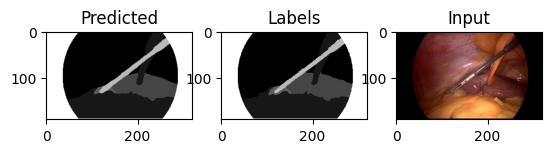

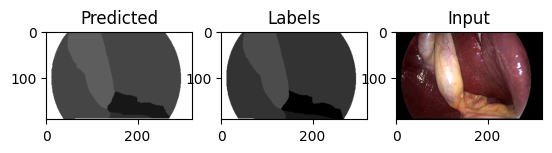

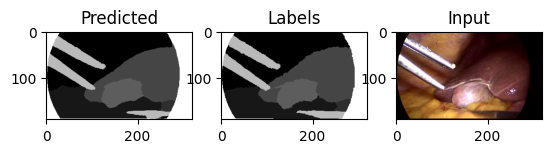

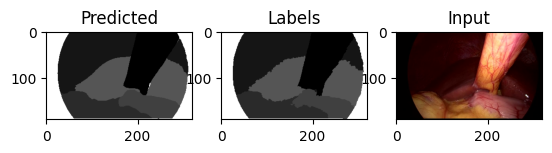

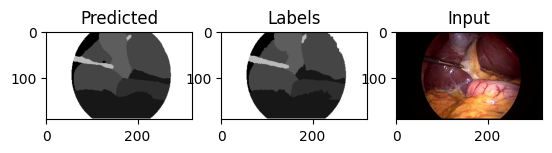

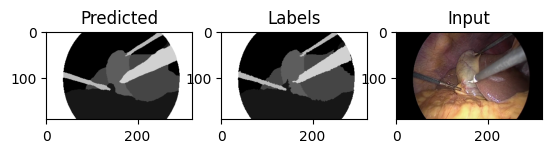

Test loss: 1.704642


1.7046420326358598

In [ ]:
test_eval(test_dataloader, wavelet_unet_trained, loss)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(wavelet_unet_trained, data_dir + f"saved_models/models/wavelet_unet_2_{cur_time}.pt")

# EXPERIMENT 2 TRANSFER LEARNING USING A SPECIFIC MODEL

This model is defined by the group, and therefore does not have a pretrained model to use.

# EXPERIMENT 3: RECOLORIZATION

No model was pretrained on the recolorization task for this new model

# EXPERIMENT 4: DATA AUGMENTATION

Here, we apply random horizontal/vertical flips to generate valid data augmentations

## Apply Data Augmentation

In [ ]:
# Redefine ImageDataset
class ImageDatasetDataAug(Dataset):
  def __init__(self, data, mask_json, req_transforms=None, data_aug=[]):
    self.data = data
    self.mask_json = mask_json
    self.transforms = req_transforms
    self.data_aug = data_aug


    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    for i in range(len(self.data_aug)):
      if random.random() > 0.5:
        data_aug = self.data_aug[i]
        img = data_aug(img)
        mask = data_aug(mask)


    return img, mask

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

data_aug = [transforms.functional.vflip, transforms.functional.hflip]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


## WaveletUNet

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Redefine Model

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.077939             0.090494             0                    0.090494        695.904129     
2          0.071362             0.083991             0                    0.083991        895.106942     
4          0.067536             0.080017             0                    0.080017        1100.250859    
6          0.065159             0.077485             0                    0.077485        1309.134187    
8          0.063691             0.075978             0                    0.075978        1517.369928    
10         0.062601             0.074768             0                    0.074768        1726.132667    
12         0.061903             0.073917             0                    0.073917        1926.729873    
14         0.061081             0.073162             0                    0.073162        2130.149396    
16         0.060535         

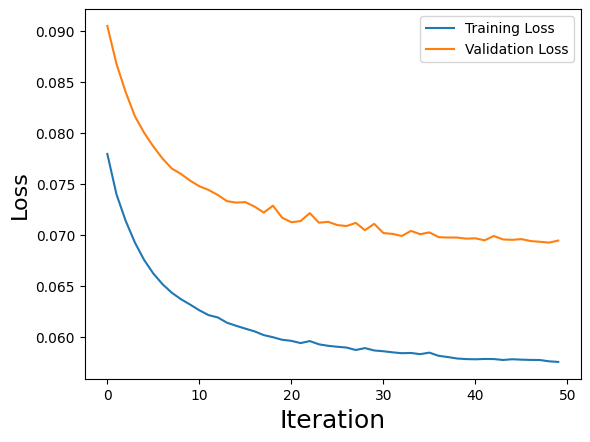

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = WaveletUNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_data_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs)

In [ ]:
dice_score_dataset(unet_data_aug, test_dataloader, n_classes)

0.8683233013230055

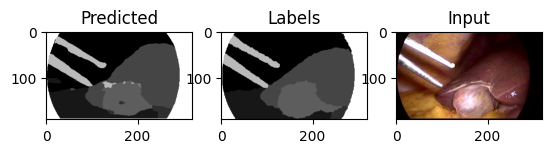

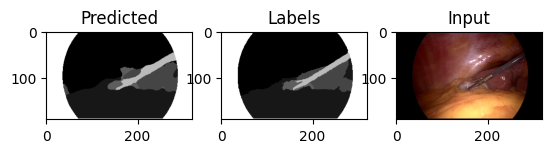

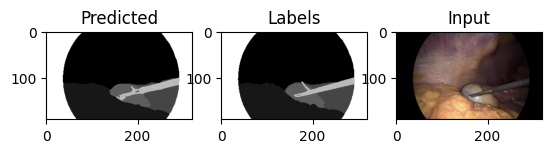

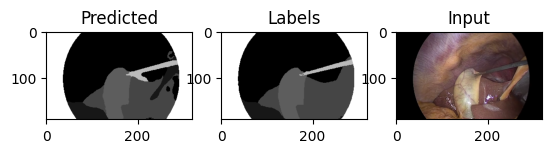

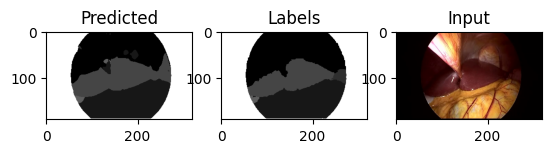

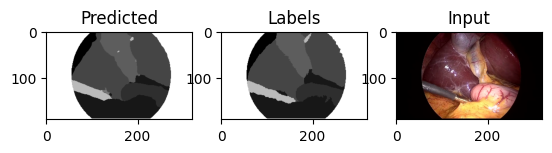

Test loss: 1.721423


1.7214230015541168

In [ ]:
test_eval(test_dataloader, unet_data_aug, loss)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_data_aug, data_dir + f"saved_models/models/wavelet_unet_data_aug_{cur_time}.pt")